In [1]:
import biotite.sequence as biotite_seq
import biotite.sequence.align as align
substitution_matrix = align.SubstitutionMatrix.std_protein_matrix()
import glob
import pandas as pd
import wandb
import itertools
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

In [2]:
api = wandb.Api()
eps = 1e-3

In [3]:

def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

def get_diversity(seqs):
    seqs = [biotite_seq.ProteinSequence(seq) for seq in seqs]
    scores = []
    for pair in itertools.combinations(seqs, 2):
    # for i in range(len(seqs)):
        # for j in range(i+1, len(seqs)):
        alignment = align.align_optimal(pair[0], pair[1], substitution_matrix, local=False, max_number=1)[0]
        scores.append(align.get_sequence_identity(alignment))
    scores = torch.FloatTensor(scores)
    return torch.mean(scores)


def get_novelty(dataset_seqs, sampled_seqs):
    sampled_seqs = [biotite_seq.ProteinSequence(seq) for seq in sampled_seqs]
    dataset_seqs = [biotite_seq.ProteinSequence(seq) for seq in dataset_seqs]
    min_dists = []
    for sample in sampled_seqs:
        dists = []
        sample_repeated = itertools.repeat(sample, len(dataset_seqs))
        for s_0, x_0 in zip(sample_repeated, dataset_seqs):
             alignment = align.align_optimal(s_0, x_0, substitution_matrix, local=False, max_number=1)[0]
             dists.append(align.get_sequence_identity(alignment))
        min_dists.append(min(dists))
    min_dists = torch.FloatTensor(min_dists)
    return torch.mean(min_dists)

In [4]:
oracle_maximize = True
k = 50
AL_BATCH_SIZE = 32

sf_train_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/sf/data_train.csv"
sf_test_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/sf/data_test.csv"
sf_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-03_11-56-45"
sf_run_path = "nikita0209/AMP-DKL/zgoc6a5q"

mf_train_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/mf/data_train.csv"
mf_test_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/mf/data_test.csv"
mf_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-01_23-18-47"
mf_run_path = "nikita0209/AMP-DKL/tk7kmfj4"

In [5]:
def get_performance(train_dataset, test_dataset, logdir, run_path, oracle_maximize, is_mf=False, eps=1e-3):
    initial_train_dataset = pd.read_csv(train_dataset, index_col=0)
    initial_test_dataset = pd.read_csv(test_dataset, index_col=0)

    initial_train_samples = initial_train_dataset["samples"].values
    initial_test_samples = initial_test_dataset["samples"].values
    # or as lists add them together
    initial_dataset_samples = np.concatenate([initial_train_samples, initial_test_samples]).tolist()
    if is_mf==True:
        initial_dataset_samples = [sample.split(";")[0] for sample in initial_dataset_samples]
    # files_with_sampled_sequences = glob.glob(os.path.join(logdir, "data/*sampled_iter*.csv"))
    # k = 10

    pkl_file = find_pkl_file(logdir)
    culm_pkl = pd.read_pickle(pkl_file)
    culm_samples = culm_pkl['cumulative_sampled_samples']
    culm_energies = culm_pkl['cumulative_sampled_energies']


    metric_diversity = []
    metric_novelty = []
    metric_energy = []
    metric_cost = []
    # mean_energy_from_wandb = run.history(keys=["mean_energy_top{}".format(k)])
    # mean_energy_from_wandb = mean_energy_from_wandb["mean_energy_top{}".format(k)].values
    run = api.run(run_path)
    post_al_cum_cost = run.history(keys=["post_al_cum_cost"])
    post_al_cum_cost = np.unique(post_al_cum_cost['post_al_cum_cost'])

    steps = np.arange(start = AL_BATCH_SIZE, stop = len(culm_samples), step = AL_BATCH_SIZE, dtype=int)
    for idx, upper_bound in enumerate(steps):
        culm_samples_curr_iter = culm_samples[0:upper_bound]
        culm_sampled_energies_curr_iter = culm_energies[0:upper_bound]

        idx_topk = torch.argsort(culm_sampled_energies_curr_iter, descending=oracle_maximize)[:k].tolist()
        samples_topk = [culm_samples_curr_iter[i] for i in idx_topk]
        energies_topk = [culm_sampled_energies_curr_iter[i] for i in idx_topk]
        mean_energy_topk = torch.mean(torch.FloatTensor(energies_topk))
        # diff = abs(mean_energy_topk-mean_energy_from_wandb[idx])
        # if diff>eps:
            # print("ERROR: energy from wandb does not match for the {}th iteration".format(idx))
        metric_energy.append(mean_energy_topk.numpy())
        mean_diversity_topk = get_diversity(samples_topk)
        mean_novelty_topk = get_novelty(sampled_seqs=samples_topk, dataset_seqs=initial_dataset_samples)
        metric_diversity.append(mean_diversity_topk.numpy())
        metric_novelty.append(mean_novelty_topk.numpy())
        metric_cost.append(post_al_cum_cost[idx])

    # PLOT METRICS
    reward = np.array(metric_energy)
    diversity = np.array(metric_diversity)
    novelty = np.array(metric_novelty)
    cost = np.array(metric_cost)

    return reward, diversity, novelty, cost

In [6]:
sf_reward, sf_diversity, sf_novelty, sf_cost = get_performance(sf_train_dataset, sf_test_dataset, sf_logdir, sf_run_path, oracle_maximize)
mf_reward, mf_diversity, mf_novelty, mf_cost = get_performance(mf_train_dataset, mf_test_dataset, mf_logdir, mf_run_path, oracle_maximize, is_mf=True)


/tmp/ipykernel_36376/575738248.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


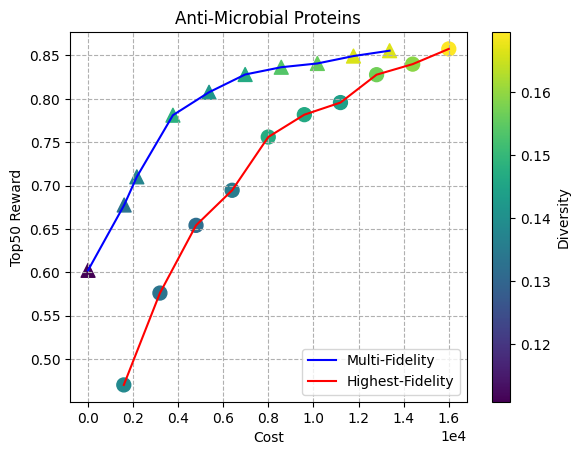

In [7]:
# Create a single subplot
fig, ax = plt.subplots()

# Plot the two line curves
mf_plot = ax.plot(mf_cost, mf_reward, color='blue', label='Multi-Fidelity')
sf_plot = ax.plot(sf_cost, sf_reward, color='red', label='Highest-Fidelity')

# Set the title and axis labels
ax.set_title('Anti-Microbial Proteins')
ax.set_xlabel('Cost')
ax.set_ylabel('Top{} Reward'.format(k))
# add grid
ax.grid(True, linestyle='--')
# convert cost labels to exponential
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Add a legend
ax.legend(loc='lower right')

# Create a single ScalarMappable object for the colorbar
div_norm = Normalize(vmin=np.min([sf_diversity, mf_diversity]), vmax=np.max([sf_diversity, mf_diversity]))
div_cmap = coolwarm
div_cmap = 'viridis'
sm = plt.cm.ScalarMappable(cmap=div_cmap, norm=div_norm)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=div_norm)


# Add scatter plots for both line curves and shade the points by diversity
mf_scatter = ax.scatter(mf_cost, mf_reward, c=mf_diversity, cmap=div_cmap, norm=div_norm, s=100, marker='^')
sf_scatter = ax.scatter(sf_cost, sf_reward, c=sf_diversity, cmap=div_cmap, norm=div_norm, s=100)

# Add a colorbar for the ScalarMappable object
cbar = fig.colorbar(sm)

# Set the label for the colorbar
cbar.ax.set_ylabel('Sequence Identity')


# Display the plot
plt.show()

In [8]:
print(sf_reward[-1], sf_diversity[-1], sf_novelty[-1], sf_cost[-1])
print(mf_reward[-1], mf_diversity[-1], mf_novelty[-1], mf_cost[-1])


0.8575791 0.1694709 0.03234742 16000
0.8555447 0.16643243 0.0019999999 13376.5


In [88]:
# # set up the plot
# fig, ax = plt.subplots()

# # plot the line
# ax.plot(sf_cost, sf_reward)

# # add the color shading
# im = ax.scatter(sf_cost, sf_reward, c=sf_diversity, cmap='viridis')
# cbar = fig.colorbar(im)

# # set the axis labels and title
# ax.set_xlabel('Cost')
# ax.set_ylabel('Energy')
# ax.set_title('Energy vs. Cost with Diversity Shading')
# # set colorbar label
# cbar.ax.set_ylabel('Diversity')

# # add grid
# ax.grid(True, linestyle='--')
# # show the plot
# plt.show()

In [89]:
# # set up the plot
# fig, ax = plt.subplots()

# # plot the line
# ax.plot(mf_cost, mf_reward)

# # add the color shading
# im = ax.scatter(mf_cost, mf_reward, c=mf_diversity, cmap='viridis')
# cbar = fig.colorbar(im)

# # set the axis labels and title
# ax.set_xlabel('Cost')
# ax.set_ylabel('Energy')
# ax.set_title('Energy vs. Cost with Diversity Shading')
# # set colorbar label
# cbar.ax.set_ylabel('Diversity')

# # show the plot
# plt.show()